## Purpose

#### 1. Understanding GLM: Robust Linear Regression
#### 2. Understaning Li, near and Hierarchical Linear Models in PyMC3

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
from pymc3 import *
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import theano


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\sidha\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
# generating artifical data with 100 points
size = 100
intercept = 1
slope = 2
x = np.linspace(0, 1, size)
true_regression_line = intercept + slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

# Add outliers
x_out = np.append(x, [.1, .15, .2])
y_out = np.append(y, [8, 6, 9])

data = dict(x=x_out, y=y_out)

In [11]:
data.keys()

dict_keys(['x', 'y'])

Text(0.5, 1.0, 'Raw Data')

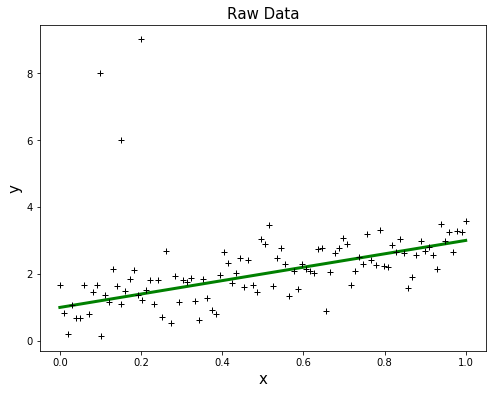

In [27]:
plt.figure(figsize = (8, 6))
plt.plot(x,true_regression_line, color='g', linewidth = 3.)
plt.plot(data['x'], data['y'], 'k+')
plt.xlabel('x', size = 15)
plt.ylabel('y', size = 15)
plt.title('Raw Data', size=15)

In [28]:
with Model() as model:
    glm.GLM.from_formula('y ~ x', data)
    trace = sample(2000, cores=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 79 seconds.


In [29]:
summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.565,0.236,1.144,2.033,0.005,0.004,2149.0,2123.0,2152.0,2047.0,1.0
x,1.248,0.408,0.490,1.996,0.009,0.006,2172.0,2172.0,2178.0,2061.0,1.0
sd,1.219,0.087,1.060,1.384,0.002,0.001,2091.0,2091.0,2113.0,2008.0,1.0


In [32]:
trace.varnames

['Intercept', 'x', 'sd_log__', 'sd']

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023394510F48>],
      dtype=object)

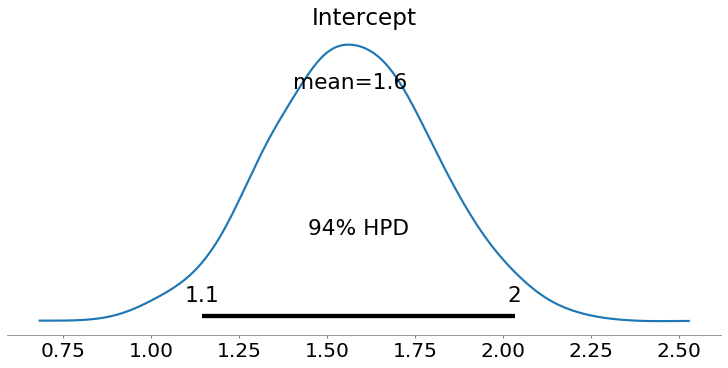

In [34]:
plots.plot_posterior(trace, varnames = ['Intercept'], figsize = (10,5))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023394515448>],
      dtype=object)

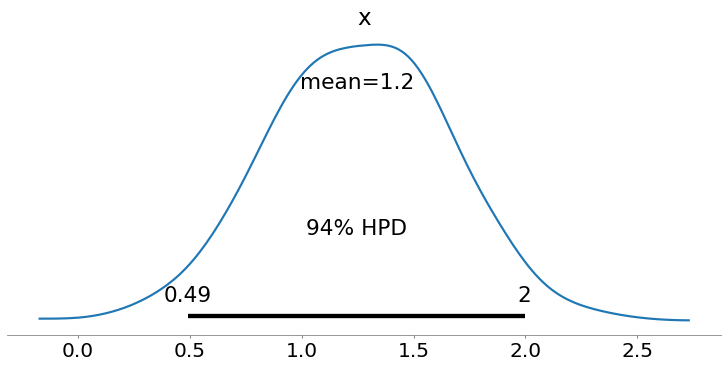

In [35]:
plots.plot_posterior(trace, varnames = ['x'], figsize = (10,5))

## Concept

### To see the fit we plot the posterior predictive regression lines by taking regression parameters from posterior distribution. We can see the predicted regression lines are weighing the outliers more.We want to limit the effect of outliers here. The normal distribution does have lot of weights distributed on tail and hence outlier will effect the fit strongly. problem is the light tails of the Normal distribution we can instead assume that our data is not normally distributed but instead distributed according to the Student T distribution which has heavier tails.



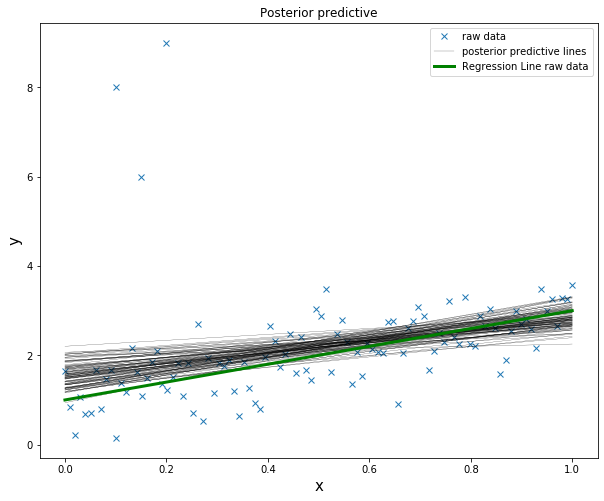

In [40]:
plt.figure(figsize=(10, 8))
plt.plot(x_out, y_out, 'x', label='raw data')
plot_posterior_predictive_glm(trace, samples=100, label='posterior predictive lines')
plt.plot(x, true_regression_line, label='Regression Line raw data', lw=3., c='g')
plt.xlabel('x', size = 15)
plt.ylabel('y', size = 15)
plt.legend()


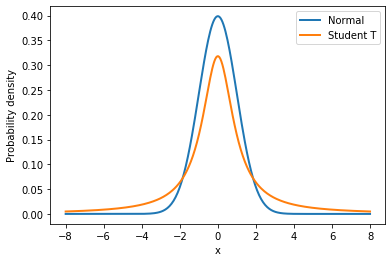

In [46]:
normal_dist = Normal.dist(mu=0, sigma=1)
t_dist = StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, theano.tensor.exp(normal_dist.logp(x_eval)).eval(), label='Normal', lw=2.)
plt.plot(x_eval, theano.tensor.exp(t_dist.logp(x_eval)).eval(), label='Student T', lw=2.)
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend();

#### We can see that the probability of values away from mean(0) is more in studentT distribution than the normal distribution hence we will use studentT distribution,The outliers are barely influencing our estimation at all because our likelihood function assumes that outliers are much more probable than under the Normal distribution. 

In [49]:
help(glm.GLM.from_formula)

Help on method from_formula in module pymc3.glm.linear:

from_formula(formula, data, priors=None, vars=None, family='normal', name='', model=None, offset=0.0, eval_env=0) method of pymc3.model.ContextMeta instance
    Creates GLM from formula.
    
    Parameters
    ----------
    formula: str - a `patsy` formula
    data: a dict-like object that can be used to look up variables referenced
        in `formula`
    eval_env: either a `patsy.EvalEnvironment` or else a depth represented as
        an integer which will be passed to `patsy.EvalEnvironment.capture()`.
        See `patsy.dmatrix` and `patsy.EvalEnvironment` for details.
    Other arguments are documented in the constructor.



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, x, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 81 seconds.


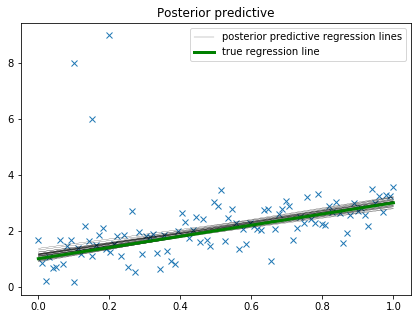

In [51]:
with Model() as model:
    family = glm.families.StudentT()
    glm.GLM.from_formula('y ~ x', data, family=family) # family defines which distribution to use
    # by default its normal distribution
    trace_robust = sample(2000, cores=2)

plt.figure(figsize=(7, 5))
plt.plot(x_out, y_out, 'x')
plot_posterior_predictive_glm(trace_robust,label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='g')
plt.legend();

In [56]:
ls

 Volume in drive C is Windows
 Volume Serial Number is C2AA-54D0

 Directory of C:\Users\sidha\Desktop\bayesian_project

04/29/2020  05:05 PM    <DIR>          .
04/29/2020  05:05 PM    <DIR>          ..
04/29/2020  04:09 PM    <DIR>          .ipynb_checkpoints
04/17/2020  04:27 PM           146,523 algo_MH_MCMC.jpeg
04/21/2020  04:30 PM    <DIR>          basics
04/29/2020  05:01 PM    <DIR>          bayesian_linear_regression_project
04/29/2020  01:01 PM    <DIR>          bayesian_multinomial_dirichlect project
04/29/2020  05:01 PM             2,331 data1999.txt
04/16/2020  05:13 PM               539 EISN_current.csv
04/17/2020  04:27 PM           138,918 likelihood_log_how_why.jpeg
04/29/2020  05:04 PM           215,091 lin_regression.ipynb
04/15/2020  09:18 PM           266,881 LinearRegression_example.ipynb
04/28/2020  11:38 AM    <DIR>          MCMC_sleep_awake project
04/23/2020  03:01 PM         1,177,896 MCMC_sunspot_count.ipynb
04/22/2020  03:38 PM            47,890 photon flu

In [58]:
sat_data = pd.read_csv(get_data('data1999.txt'))

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\sidha\\Anaconda3\\lib\\site-packages\\pymc3\\examples\\data\\data1999.txt'